In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import math
import matplotlib.dates as mdates
import subprocess
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model

/Users/thilina/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# import numpy as np
# import pandas as pd
# import datetime as dt
# import matplotlib.pyplot as plt
# import math
# import subprocess
# from sklearn.preprocessing import MinMaxScaler
# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense
# from keras.layers import SimpleRNN
# from keras.layers import Dropout
# from keras.layers import GRU, Bidirectional
# from keras.optimizers import SGD
# from sklearn import metrics
# from sklearn.metrics import mean_squared_error

# # Function to get the version of a library
# def get_version(lib_name):
#     return subprocess.run(['pip', 'show', lib_name], stdout=subprocess.PIPE, text=True).stdout.split('\n')[1].split(': ')[1]

# # List of libraries
# libraries = ['numpy', 'pandas', 'datetime', 'matplotlib', 'math', 'scipy', 'sklearn', 'keras']

# # Get the version of each library
# library_versions = []
# for lib in libraries:
#     try:
#         version = get_version(lib)
#     except IndexError:
#         version = "Built-in"
#     library_versions.append((lib, version))

# # Create a DataFrame
# df = pd.DataFrame(library_versions, columns=['Library', 'Version'])

# # Display the DataFrame
# df


In [3]:
file_path = "data/orginal_cleaned_dataset.csv"
df_crude = pd.read_csv(file_path)
df_crude

,date,Crude_oil_price
0,2001-01-02,27.29
1,2001-01-03,27.93
2,2001-01-04,27.95
3,2001-01-05,28.02
4,2001-01-06,27.44
...,...,...
8312,2023-10-06,82.83
8313,2023-10-07,85.89
8314,2023-10-08,85.89
8315,2023-10-09,85.89


In [4]:
df_crude_index = df_crude.set_index('date')
df_crude_index

,Crude_oil_price
date,
2001-01-02,27.29
2001-01-03,27.93
2001-01-04,27.95
2001-01-05,28.02
2001-01-06,27.44
...,...
2023-10-06,82.83
2023-10-07,85.89
2023-10-08,85.89


<Axes: xlabel='date'>

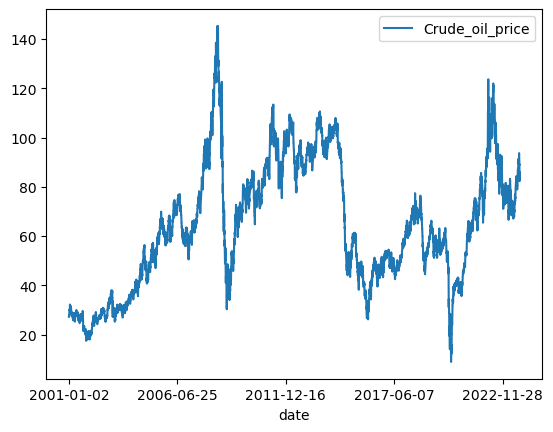

In [5]:
data = df_crude_index
data['Crude_oil_price'].plot(legend=True)

/var/folders/27/gbz_5drj4l13l6x8mnk54j1w0000gn/T/ipykernel_2003/3005304235.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


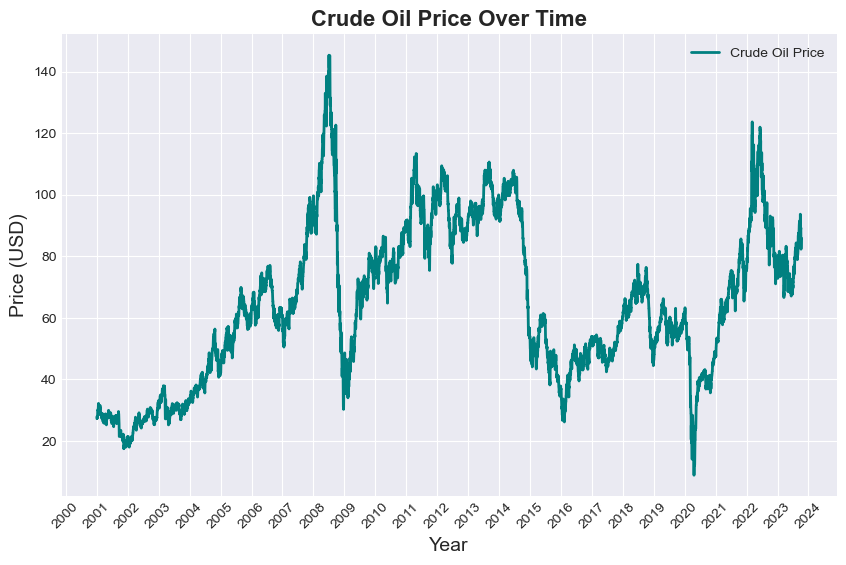

In [6]:
data.index = pd.to_datetime(data.index)
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data['Crude_oil_price'], label='Crude Oil Price', color='teal', linewidth=2)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_title('Crude Oil Price Over Time', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Price (USD)', fontsize=14)
ax.legend()
plt.xticks(rotation=45)
ax.grid(True)
plt.show()

In [6]:
# Setting 80 percent data for training
training_data_len = math.ceil(len(data) * .8)
training_data_len

#Splitting the dataset
train_data = data[:training_data_len].iloc[:,:1]
test_data = data[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(6654, 1) (1663, 1)


In [7]:
train_data

,Crude_oil_price
date,
2001-01-02,27.29
2001-01-03,27.93
2001-01-04,27.95
2001-01-05,28.02
2001-01-06,27.44
...,...
2019-03-18,59.09
2019-03-19,59.12
2019-03-20,60.12


In [8]:
test_data

,Crude_oil_price
date,
2019-03-23,58.71
2019-03-24,58.71
2019-03-25,58.71
2019-03-26,59.87
2019-03-27,59.39
...,...
2023-10-06,82.83
2023-10-07,85.89
2023-10-08,85.89


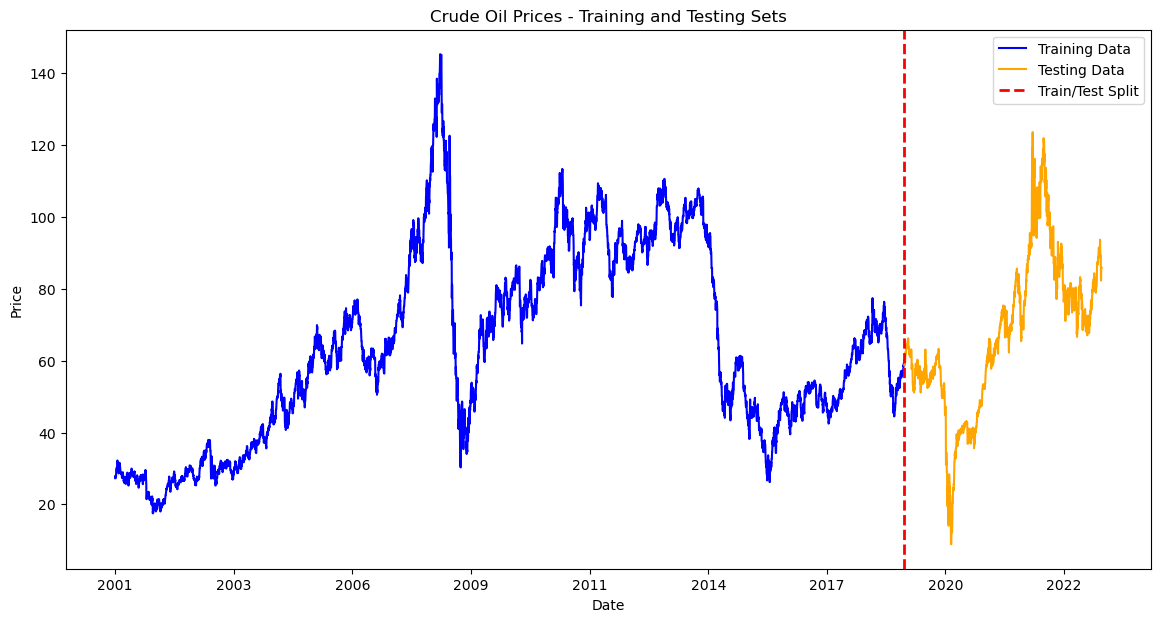

In [9]:
# Plotting the training and testing sets
plt.figure(figsize=(14, 7))

# Training data plot
plt.plot(train_data.index, train_data['Crude_oil_price'], color='blue', label='Training Data')

# Testing data plot
plt.plot(test_data.index, test_data['Crude_oil_price'], color='orange', label='Testing Data')

# Annotating the plot
plt.axvline(x=train_data.index[-1], color='red', linestyle='--', linewidth=2, label='Train/Test Split')

# Formatting x-axis to show only the year
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: pd.Timestamp(data.index[int(x)]).strftime('%Y') if int(x) < len(data) else ''))

plt.title('Crude Oil Prices - Training and Testing Sets')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()


In [10]:
# Selecting Crude_oil_price values
dataset_train = train_data.Crude_oil_price.values

# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(6654, 1)

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))

# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

[[0.07659808]
 [0.08160551]
 [0.08176199]
 [0.08230968]
 [0.07777169]]


In [12]:
# Selecting Open Price values
dataset_test = test_data.Crude_oil_price.values

# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1))

# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5])

[0.43406258] [0.43406258] [0.43406258] [0.44417328] [0.43998954]


In [13]:
X_train = []
y_train = []
for i in range(100, len(scaled_train)):
    X_train.append(scaled_train[i-100:i, 0])
    y_train.append(scaled_train[i, 0])

In [14]:
X_test = []
y_test = []
for i in range(100, len(scaled_test)):
    X_test.append(scaled_test[i-100:i, 0])
    y_test.append(scaled_test[i, 0])

In [15]:
# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)

X_train : (6554, 100, 1) y_train : (6554, 1)


In [16]:
# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)

X_test : (1563, 100, 1) y_test : (1563, 1)


### **RNN**

In [17]:
# initializing the RNN
regressor = Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True,
                        input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True))

regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True))

regressor.add( SimpleRNN(units = 50))

# adding the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

# compiling RNN
regressor.compile(optimizer = SGD(learning_rate=0.01,
                                  momentum=0.9,
                                  nesterov=True),
                  loss = "mean_squared_error")

# # fitting the model
regressor.fit(X_train, y_train, epochs = 5, batch_size = 2)
regressor.summary()

# Visualizing the model architecture
# plot_model(regressor, to_file='rnn_model.png', show_shapes=True, show_layer_names=True)

Epoch 1/5
3277/3277 [==============================] - 57s 17ms/step - loss: 0.0035
Epoch 2/5
3277/3277 [==============================] - 56s 17ms/step - loss: 6.5364e-04
Epoch 3/5
3277/3277 [==============================] - 56s 17ms/step - loss: 5.5963e-04
Epoch 4/5
3277/3277 [==============================] - 56s 17ms/step - loss: 5.0651e-04
Epoch 5/5
3277/3277 [==============================] - 57s 18ms/step - loss: 4.6032e-04
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100, 50)           2600      
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 50)           5050      
                                                                 
 simple_rnn_2 (S

### **LSTM**

In [18]:
#Initialising the model
regressorLSTM = Sequential()

#Adding LSTM layers
regressorLSTM.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(LSTM(50, return_sequences=True))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(LSTM(50, return_sequences=False))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(Dense(25))

# Adding the output layer
regressorLSTM.add(Dense(1))

# Compiling the model
regressorLSTM.compile(optimizer='adam', loss='mean_squared_error')

# Fitting the model
history = regressorLSTM.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
regressorLSTM.summary()

Epoch 1/10
164/164 [==============================] - 10s 50ms/step - loss: 0.0080 - val_loss: 4.1500e-04
Epoch 2/10
164/164 [==============================] - 8s 50ms/step - loss: 0.0022 - val_loss: 4.0186e-04
Epoch 3/10
164/164 [==============================] - 8s 49ms/step - loss: 0.0016 - val_loss: 4.1073e-04
Epoch 4/10
164/164 [==============================] - 8s 50ms/step - loss: 0.0014 - val_loss: 4.3971e-04
Epoch 5/10
164/164 [==============================] - 8s 50ms/step - loss: 0.0012 - val_loss: 3.3672e-04
Epoch 6/10
164/164 [==============================] - 8s 51ms/step - loss: 0.0011 - val_loss: 3.7933e-04
Epoch 7/10
164/164 [==============================] - 8s 51ms/step - loss: 9.9789e-04 - val_loss: 2.5090e-04
Epoch 8/10
164/164 [==============================] - 8s 50ms/step - loss: 9.3976e-04 - val_loss: 3.9380e-04
Epoch 9/10
164/164 [==============================] - 8s 50ms/step - loss: 8.8323e-04 - val_loss: 2.2274e-04
Epoch 10/10
164/164 [=====================

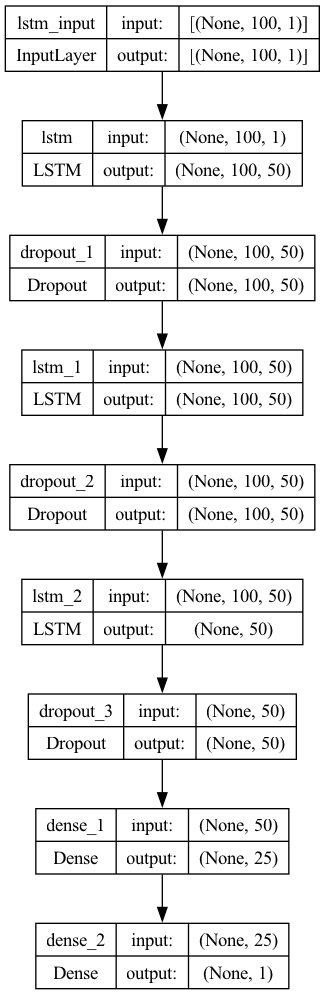

In [19]:
plot_model(regressorLSTM, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

### **GRU**

In [20]:
#Initialising the model
regressorGRU = Sequential()

# GRU layers with Dropout regularisation
regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     input_shape=(X_train.shape[1],1),
                     activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     activation='tanh'))

regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     activation='tanh'))

regressorGRU.add(GRU(units=50,
                     activation='tanh'))

# The output layer
regressorGRU.add(Dense(units=1,
                       activation='relu'))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01,
                                   momentum=0.9,
                                   nesterov=False),
                     loss='mean_squared_error')

# Fitting the data
regressorGRU.fit(X_train,y_train,epochs=5,batch_size=1)
regressorGRU.summary()
# plot_model(regressorGRU, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

Epoch 1/5
6554/6554 [==============================] - 166s 25ms/step - loss: 0.0011
Epoch 2/5
6554/6554 [==============================] - 163s 25ms/step - loss: 6.1810e-04
Epoch 3/5
6554/6554 [==============================] - 163s 25ms/step - loss: 5.5932e-04
Epoch 4/5
6554/6554 [==============================] - 161s 25ms/step - loss: 4.9024e-04
Epoch 5/5
6554/6554 [==============================] - 156s 24ms/step - loss: 4.6387e-04
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 50)           7950      
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 gru_1 (GRU)                 (None, 100, 50)           15300     
                                                                 
 gru_2 (G

In [21]:
# predictions with X_test data
y_RNN = regressor.predict(X_test)
y_LSTM = regressorLSTM.predict(X_test)
y_GRU = regressorGRU.predict(X_test)

49/49 [==============================] - 1s 13ms/step


In [22]:
# scaling back from 0-1 to original
y_RNN_O = scaler.inverse_transform(y_RNN)
y_LSTM_O = scaler.inverse_transform(y_LSTM)
y_GRU_O = scaler.inverse_transform(y_GRU)

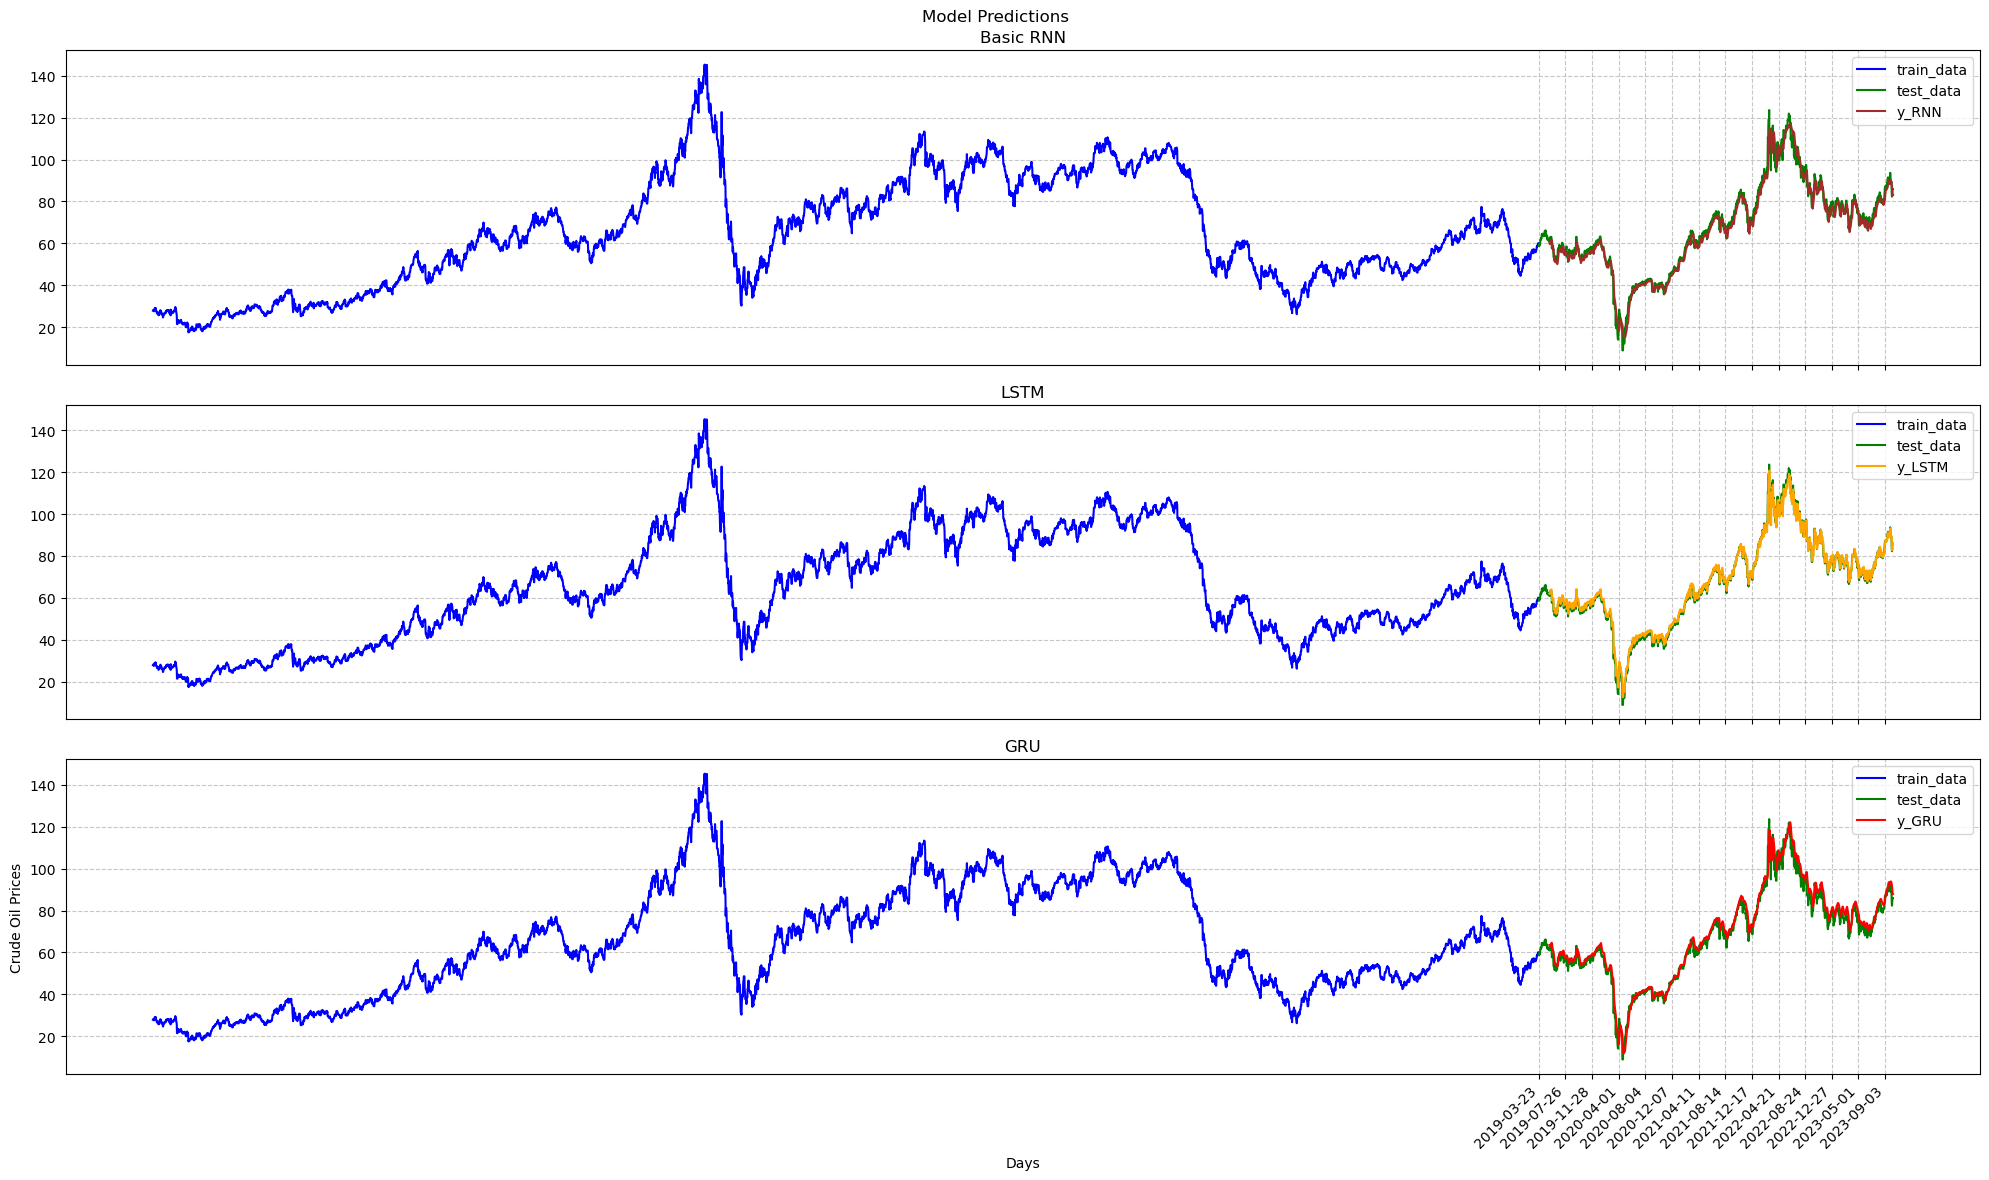

In [20]:
fig, axs = plt.subplots(3,figsize =(20,12),sharex=True, sharey=True)
fig.suptitle('Model Predictions')

#Plot for RNN predictions
axs[0].plot(train_data.index[150:], train_data.Crude_oil_price[150:], label = "train_data", color = "b")
axs[0].plot(test_data.index, test_data.Crude_oil_price, label = "test_data", color = "g")
axs[0].plot(test_data.index[50:], y_RNN_O, label = "y_RNN", color = "brown")
axs[0].legend()
axs[0].title.set_text("Basic RNN")

#Plot for LSTM predictions
axs[1].plot(train_data.index[150:], train_data.Crude_oil_price[150:], label = "train_data", color = "b")
axs[1].plot(test_data.index, test_data.Crude_oil_price, label = "test_data", color = "g")
axs[1].plot(test_data.index[50:], y_LSTM_O, label = "y_LSTM", color = "orange")
axs[1].legend()
axs[1].title.set_text("LSTM")

#Plot for GRU predictions
axs[2].plot(train_data.index[150:], train_data.Crude_oil_price[150:], label = "train_data", color = "b")
axs[2].plot(test_data.index, test_data.Crude_oil_price, label = "test_data", color = "g")
axs[2].plot(test_data.index[50:], y_GRU_O, label = "y_GRU", color = "red")
axs[2].legend()
axs[2].title.set_text("GRU")

plt.xlabel("Days")
plt.ylabel("Crude Oil Prices")

n = 125
for ax in axs:
    ax.set_xticks(test_data.index[::n])
    ax.set_xticklabels(test_data.index[::n], rotation=45, ha="right")

# Add grid lines
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [23]:
# scaling back from 0-1 to original
Y_test_O = scaler.inverse_transform(y_test)

In [24]:
mse_RNN = mean_squared_error(Y_test_O, y_RNN_O)
mse_LSTM = mean_squared_error(Y_test_O, y_LSTM_O)
mse_GRU = mean_squared_error(Y_test_O, y_GRU_O)

print("Mean Squared Error for RNN:", mse_RNN)
print("Mean Squared Error for LSTM:", mse_LSTM)
print("Mean Squared Error for GRU:", mse_GRU)

Mean Squared Error for RNN: 9.863288303696454
Mean Squared Error for LSTM: 11.1676078504716
Mean Squared Error for GRU: 10.166323172468745


In [25]:
rmse_RNN = np.sqrt(mse_RNN)
rmse_LSTM = np.sqrt(mse_LSTM)
rmse_GRU = np.sqrt(mse_GRU)

print("Root Mean Squared Error for RNN:", rmse_RNN)
print("Root Mean Squared Error for LSTM:", rmse_LSTM)
print("Root Mean Squared Error for GRU:", rmse_GRU)

Root Mean Squared Error for RNN: 3.1405872545905256
Root Mean Squared Error for LSTM: 3.3417970989381747
Root Mean Squared Error for GRU: 3.1884672136418066


#### Prediction for the test set

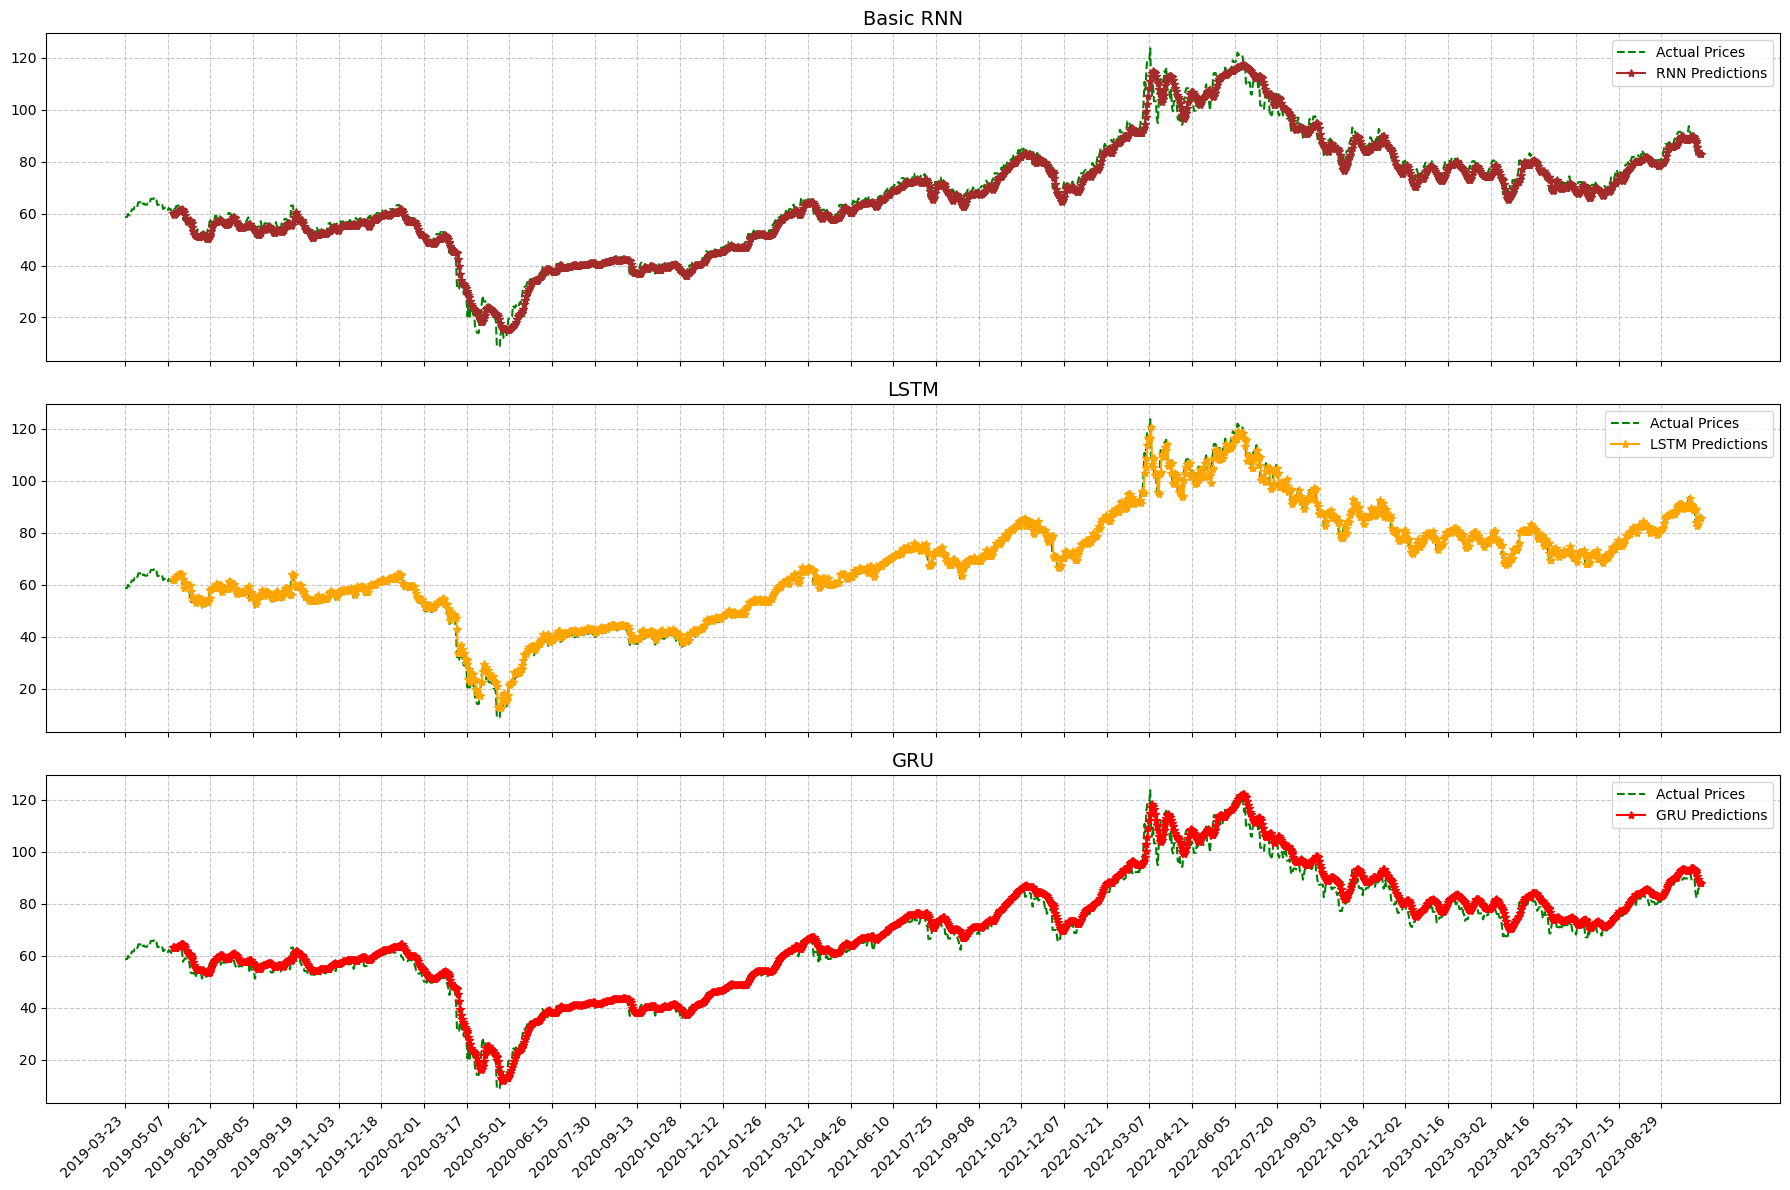

In [24]:
fig, axs = plt.subplots(3, figsize=(18, 12), sharex=True, sharey=True)
# fig.suptitle('Model Predictions', fontsize=16, y=0.95)

# Plot for RNN predictions (last 100 data points)
axs[0].plot(test_data.index, test_data.Crude_oil_price, label="Actual Prices", color="g", linestyle='--')
axs[0].plot(test_data.index[50:], y_RNN_O, label="RNN Predictions", color="brown", marker='*')
axs[0].legend()
axs[0].set_title("Basic RNN", fontsize=14)

# Plot for LSTM predictions (last 100 data points)
axs[1].plot(test_data.index, test_data.Crude_oil_price, label="Actual Prices", color="g", linestyle='--')
axs[1].plot(test_data.index[50:], y_LSTM_O, label="LSTM Predictions", color="orange", marker='*')
axs[1].legend()
axs[1].set_title("LSTM", fontsize=14)

# Plot for GRU predictions (last 100 data points)
axs[2].plot(test_data.index, test_data.Crude_oil_price, label="Actual Prices", color="g", linestyle='--')
axs[2].plot(test_data.index[50:], y_GRU_O, label="GRU Predictions", color="red", marker='*')
axs[2].legend()
axs[2].set_title("GRU", fontsize=14)

# Set common labels
# fig.text(0.5, 0.08, "Days", ha="center", va="center", fontsize=14)
# fig.text(0.08, 0.5, "Crude Oil Prices", ha="center", va="center", rotation="vertical", fontsize=14)

# Customize x-axis ticks (show every 5th date for example)
n = 45
for ax in axs:
    ax.set_xticks(test_data.index[::n])
    ax.set_xticklabels(test_data.index[::n], rotation=45, ha="right")

# Add grid lines
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


#### Predictions for last 100 days

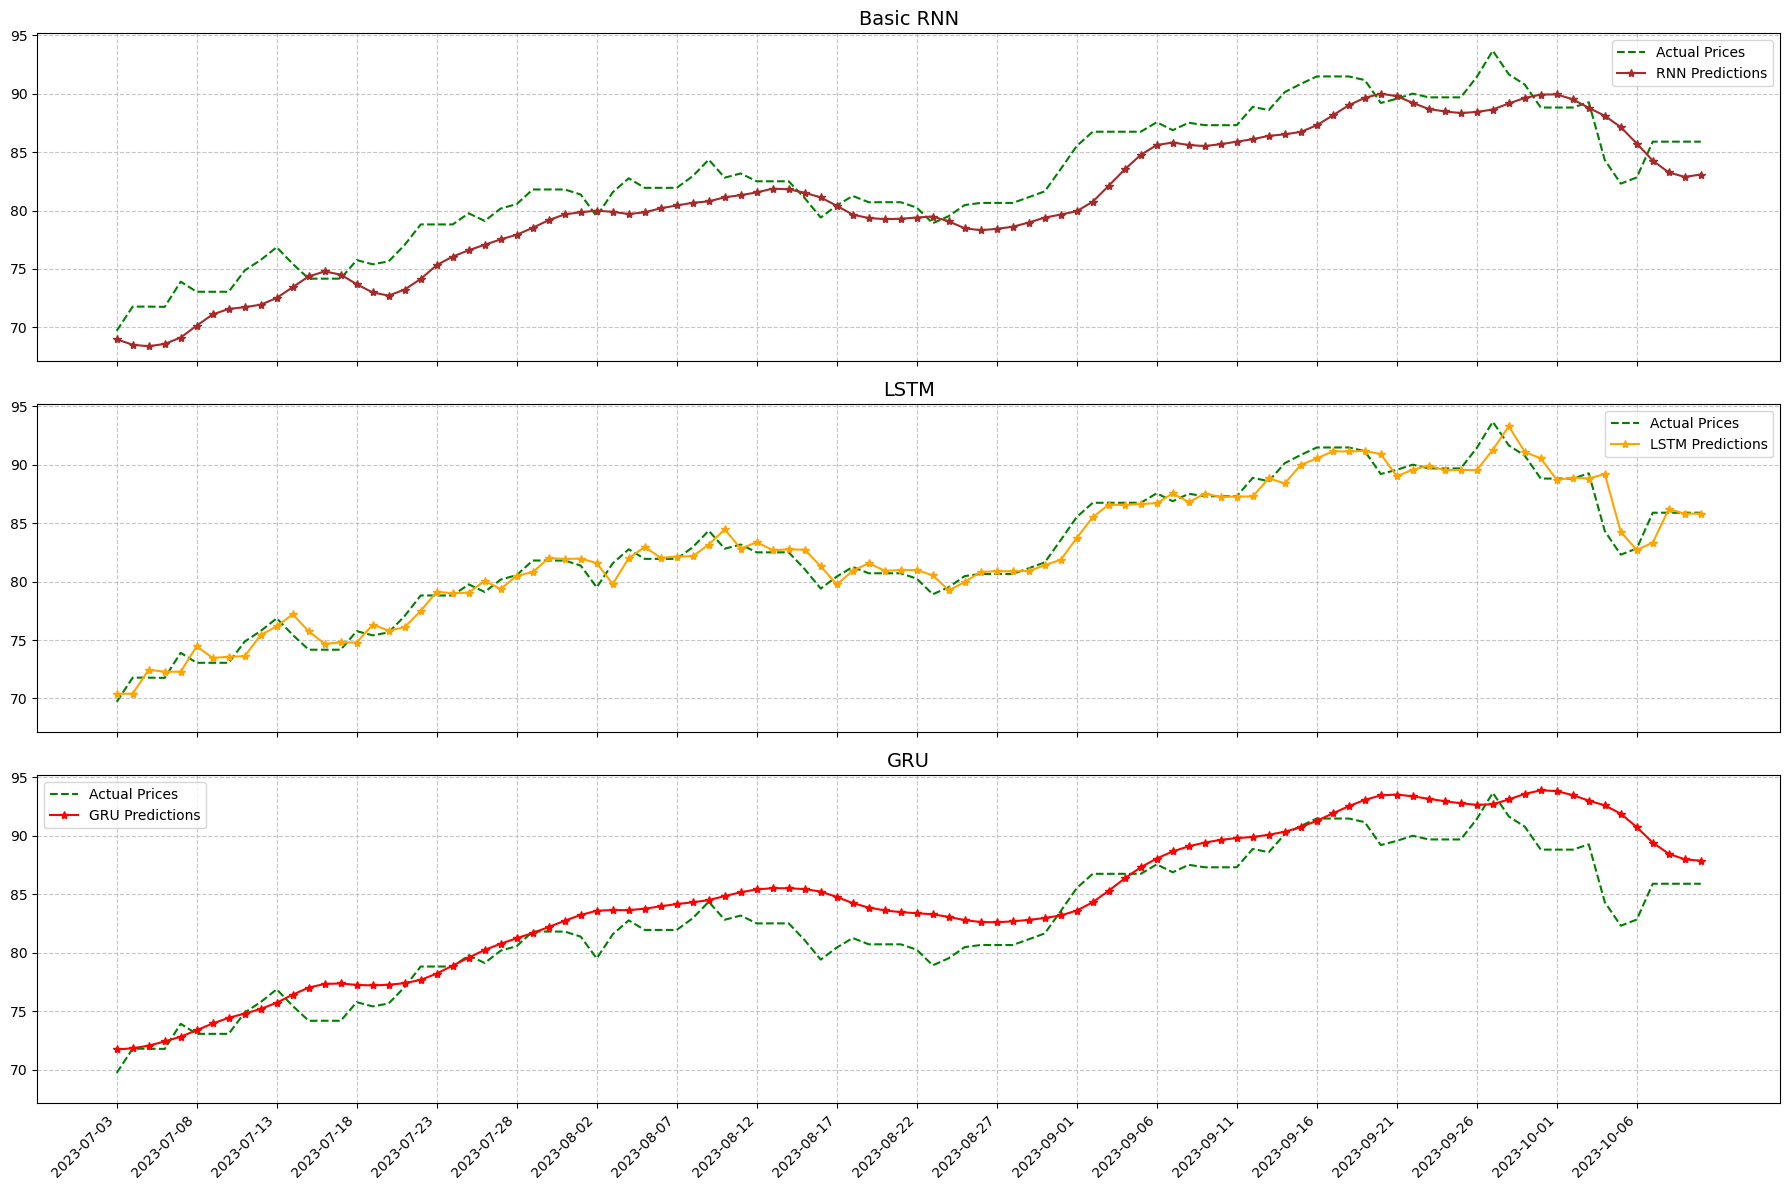

In [25]:
# Extract the last 100 dates from the test set
last_100_dates = test_data.index[-100:]

fig, axs = plt.subplots(3, figsize=(18, 12), sharex=True, sharey=True)
# fig.suptitle('Model Predictions', fontsize=16, y=0.95)

# Plot for RNN predictions (last 100 data points)
axs[0].plot(last_100_dates, test_data.Crude_oil_price[-100:], label="Actual Prices", color="g", linestyle='--')
axs[0].plot(last_100_dates[-100:], y_RNN_O[-100:], label="RNN Predictions", color="brown", marker='*')
axs[0].legend()
axs[0].set_title("Basic RNN", fontsize=14)

# Plot for LSTM predictions (last 100 data points)
axs[1].plot(last_100_dates, test_data.Crude_oil_price[-100:], label="Actual Prices", color="g", linestyle='--')
axs[1].plot(last_100_dates[-100:], y_LSTM_O[-100:], label="LSTM Predictions", color="orange", marker='*')
axs[1].legend()
axs[1].set_title("LSTM", fontsize=14)

# Plot for GRU predictions (last 100 data points)
axs[2].plot(last_100_dates, test_data.Crude_oil_price[-100:], label="Actual Prices", color="g", linestyle='--')
axs[2].plot(last_100_dates[-100:], y_GRU_O[-100:], label="GRU Predictions", color="red", marker='*')
axs[2].legend()
axs[2].set_title("GRU", fontsize=14)

# Set common labels
# fig.text(0.5, 0.08, "Days", ha="center", va="center", fontsize=14)
# fig.text(0.05, 0.5, "Crude Oil Prices", ha="center", va="center", rotation="vertical", fontsize=14)

# Customize x-axis ticks (show every 5th date for example)
n = 5
for ax in axs:
    ax.set_xticks(last_100_dates[::n])
    ax.set_xticklabels(last_100_dates[::n], rotation=45, ha="right")

# Add grid lines
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
